# Zarr Dataset Exploration

This notebook explores the gameplay recordings converted to zarr format by `convert_to_zarr.py`.

The dataset contains:
- **Frames**: Video frames as `[N, C, H, W]` uint8 arrays
- **State**: Game state values as `[N, num_attributes]` float32 arrays
- **Actions**: Input actions as `[N, num_keys]` boolean arrays


In [1]:
import zarr
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Configure matplotlib for better plots
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100


## 1. Load Dataset


In [2]:
# Path to your zarr dataset
dataset_path = Path('../dataset/test_dataset.zarr')  # Adjust this path as needed

# Open zarr dataset
zarr_root = zarr.open(str(dataset_path), mode='r')

print(f"Dataset loaded from: {dataset_path}")
print(f"\nDataset keys: {list(zarr_root.keys())}")


Dataset loaded from: ..\dataset\test_dataset.zarr

Dataset keys: ['episode_0']


## 2. Dataset Metadata


In [3]:
# Print global metadata
print("Global Metadata:")
for key, value in zarr_root.attrs.items():
    if key not in ['keys', 'attributes', 'raw_to_semantic']:  # Print these separately
        print(f"  {key}: {value}")

# Number of episodes
episodes = [k for k in zarr_root.keys() if k.startswith('episode_')]
print(f"\nNumber of episodes: {len(episodes)}")


Global Metadata:
  format: framewise
  source: recordings
  target_resolution: [800, 450]
  version: 1.0

Number of episodes: 1


In [4]:
# Action keys (semantic names)
if 'keys' in zarr_root.attrs:
    action_keys = zarr_root.attrs['keys']
    print(f"Action Keys ({len(action_keys)}):")
    for i, key in enumerate(action_keys):
        print(f"  [{i:2d}] {key}")


Action Keys (5):
  [ 0] move_left
  [ 1] lock_on
  [ 2] dodge_roll/dash
  [ 3] attack
  [ 4] move_forward


In [ ]:
# State attributes
if 'attributes' in zarr_root.attrs:
    state_attrs = zarr_root.attrs['attributes']
    print(f"State Attributes ({len(state_attrs)}):")
    for i, attr in enumerate(state_attrs):
        print(f"  [{i:2d}] {attr}")


State Attributes (19):
  [ 0] HeroHp
  [ 1] HeroMaxHp
  [ 2] HeroSp
  [ 3] HeroMaxSp
  [ 4] HeroFp
  [ 5] HeroMaxFp
  [ 6] HeroGlobalPosX
  [ 7] HeroGlobalPosY
  [ 8] HeroGlobalPosZ
  [ 9] HeroAngle
  [10] HeroAnimId
  [11] NpcHp
  [12] NpcMaxHp
  [13] NpcId
  [14] NpcGlobalPosX
  [15] NpcGlobalPosY
  [16] NpcGlobalPosZ
  [17] NpcGlobalPosAngle
  [18] NpcAnimId


## 3. Episode Information


In [6]:
# Select episode to explore
episode_idx = 0
episode = zarr_root[f'episode_{episode_idx}']

print(f"Episode {episode_idx} Information:")
print(f"  Session name: {episode.attrs.get('session_name', 'N/A')}")
print(f"  FPS: {episode.attrs.get('fps', 'N/A')}")
print(f"  Frame count: {episode.attrs.get('frame_count', 'N/A')}")
print(f"  Original resolution: {episode.attrs.get('original_resolution', 'N/A')}")
print(f"  Stored resolution: {episode.attrs.get('stored_resolution', 'N/A')}")

print(f"\nData shapes:")
print(f"  Frames: {episode['frames'].shape} ({episode['frames'].dtype})")
print(f"  State: {episode['state'].shape} ({episode['state'].dtype})")
print(f"  Actions: {episode['actions'].shape} ({episode['actions'].dtype})")


Episode 0 Information:
  Session name: rec_1763522855566_5251
  FPS: 16.723633848682883
  Frame count: 1255
  Original resolution: [2160, 3840]
  Stored resolution: [450, 800]

Data shapes:
  Frames: (1255, 3, 450, 800) (uint8)
  State: (1255, 19) (float32)
  Actions: (1255, 5) (bool)


## 4. Visualize Frames


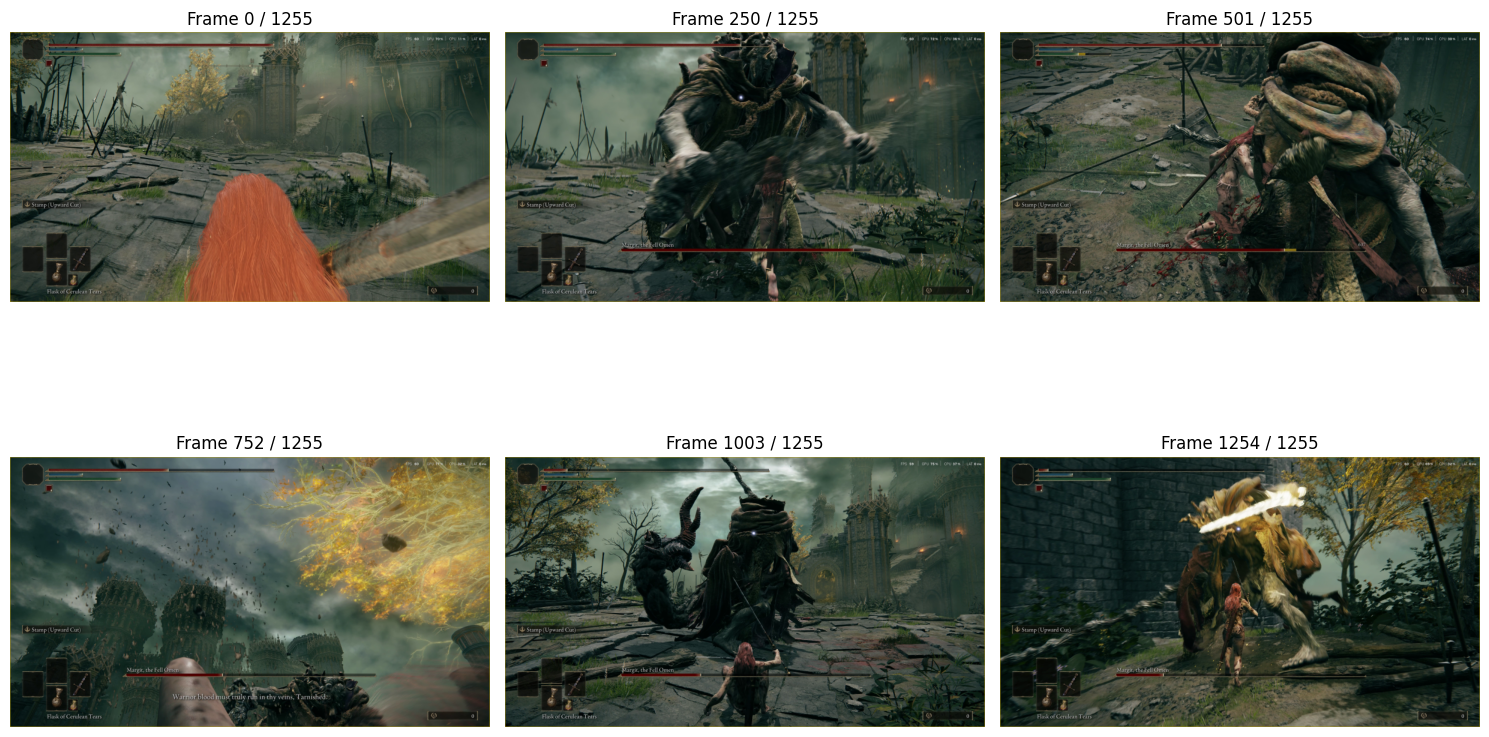

In [7]:
# Display a few frames from the episode
num_frames_to_show = 6
total_frames = episode['frames'].shape[0]
frame_indices = np.linspace(0, total_frames - 1, num_frames_to_show, dtype=int)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, frame_idx in enumerate(frame_indices):
    # Load frame (shape: [C, H, W])
    frame = episode['frames'][frame_idx]
    
    # Convert from CHW to HWC for display
    frame_hwc = np.transpose(frame, (1, 2, 0))
    
    # Convert BGR to RGB (OpenCV uses BGR)
    frame_rgb = frame_hwc[:, :, ::-1]
    
    axes[i].imshow(frame_rgb)
    axes[i].set_title(f'Frame {frame_idx} / {total_frames}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


## 5. Explore Actions Over Time


Actions shape: (1255, 5)
Action keys: ['move_left', 'lock_on', 'dodge_roll/dash', 'attack', 'move_forward']


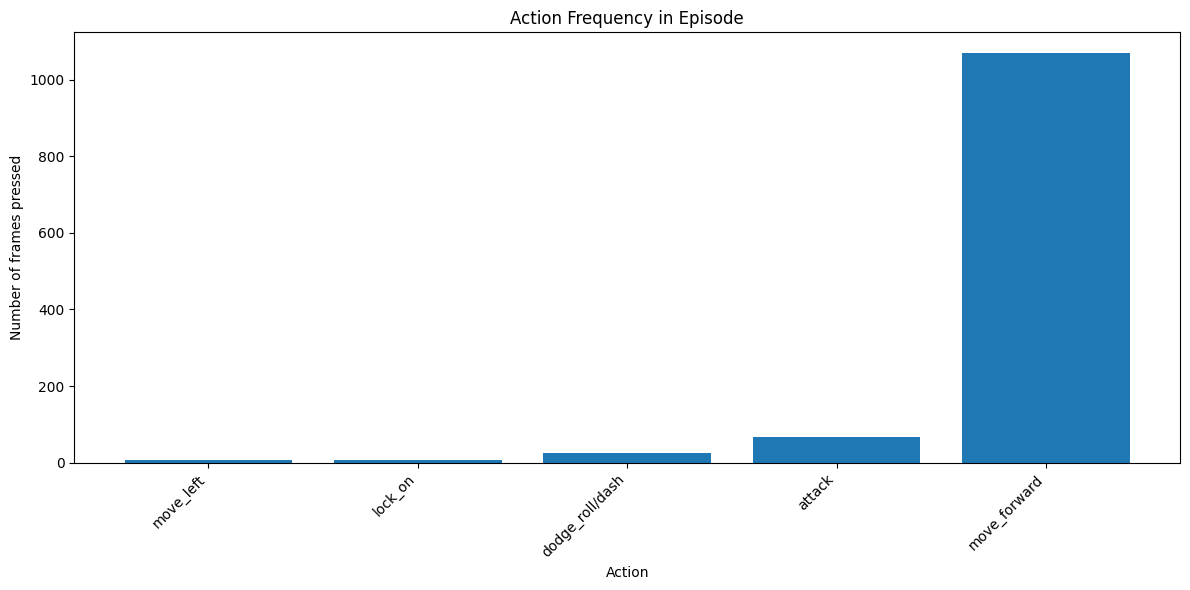

In [ ]:
# Get actions data
actions = episode['actions'][:]
action_keys = episode.attrs.get('action_keys', zarr_root.attrs.get('keys', []))

print(f"Actions shape: {actions.shape}")
print(f"Action keys: {action_keys}")

# Count how often each action is pressed
action_counts = actions.sum(axis=0)

plt.figure(figsize=(12, 6))
plt.bar(range(len(action_keys)), action_counts)
plt.xlabel('Action')
plt.ylabel('Number of frames pressed')
plt.title('Action Frequency in Episode')
plt.xticks(range(len(action_keys)), action_keys, rotation=45, ha='right')
plt.tight_layout()
plt.show()


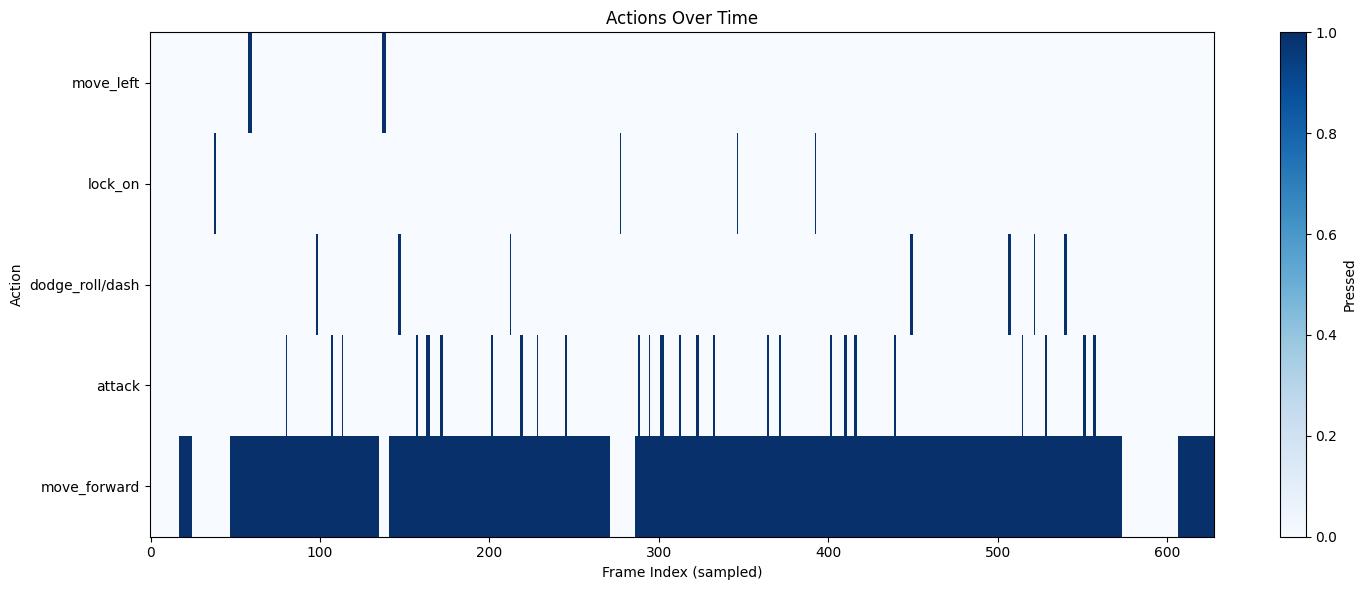

In [9]:
# Plot actions over time (heatmap)
# Sample every N frames for better visualization
sample_rate = max(1, actions.shape[0] // 500)
actions_sampled = actions[::sample_rate, :]

plt.figure(figsize=(15, 6))
plt.imshow(actions_sampled.T, aspect='auto', cmap='Blues', interpolation='nearest')
plt.colorbar(label='Pressed')
plt.xlabel('Frame Index (sampled)')
plt.ylabel('Action')
plt.title('Actions Over Time')
plt.yticks(range(len(action_keys)), action_keys)
plt.tight_layout()
plt.show()


## 6. Explore State Over Time


In [10]:
# Get state data
state = episode['state'][:]
state_attrs = episode.attrs.get('state_attributes', zarr_root.attrs.get('attributes', []))

print(f"State shape: {state.shape}")
print(f"State attributes: {state_attrs}")

# Print basic statistics for each attribute
print("\nState Statistics:")
for i, attr in enumerate(state_attrs):
    values = state[:, i]
    print(f"  {attr:20s}: min={values.min():10.2f}, max={values.max():10.2f}, mean={values.mean():10.2f}, std={values.std():10.2f}")


State shape: (1255, 19)
State attributes: ['HeroHp', 'HeroMaxHp', 'HeroSp', 'HeroMaxSp', 'HeroFp', 'HeroMaxFp', 'HeroGlobalPosX', 'HeroGlobalPosY', 'HeroGlobalPosZ', 'HeroAngle', 'HeroAnimId', 'NpcHp', 'NpcMaxHp', 'NpcId', 'NpcGlobalPosX', 'NpcGlobalPosY', 'NpcGlobalPosZ', 'NpcGlobalPosAngle', 'NpcAnimId']

State Statistics:
  HeroHp              : min=     95.00, max=   2226.00, mean=   1335.74, std=    771.08
  HeroMaxHp           : min=   2226.00, max=   2226.00, mean=   2226.00, std=      0.00
  HeroSp              : min=      6.00, max=     96.00, mean=     79.16, std=     22.82
  HeroMaxSp           : min=     96.00, max=     96.00, mean=     96.00, std=      0.00
  HeroFp              : min=     78.00, max=     78.00, mean=     78.00, std=      0.00
  HeroMaxFp           : min=     78.00, max=     78.00, mean=     78.00, std=      0.00
  HeroGlobalPosX      : min=     -4.54, max=     18.75, mean=      3.24, std=      5.97
  HeroGlobalPosY      : min=    -21.38, max=     -4.81, m

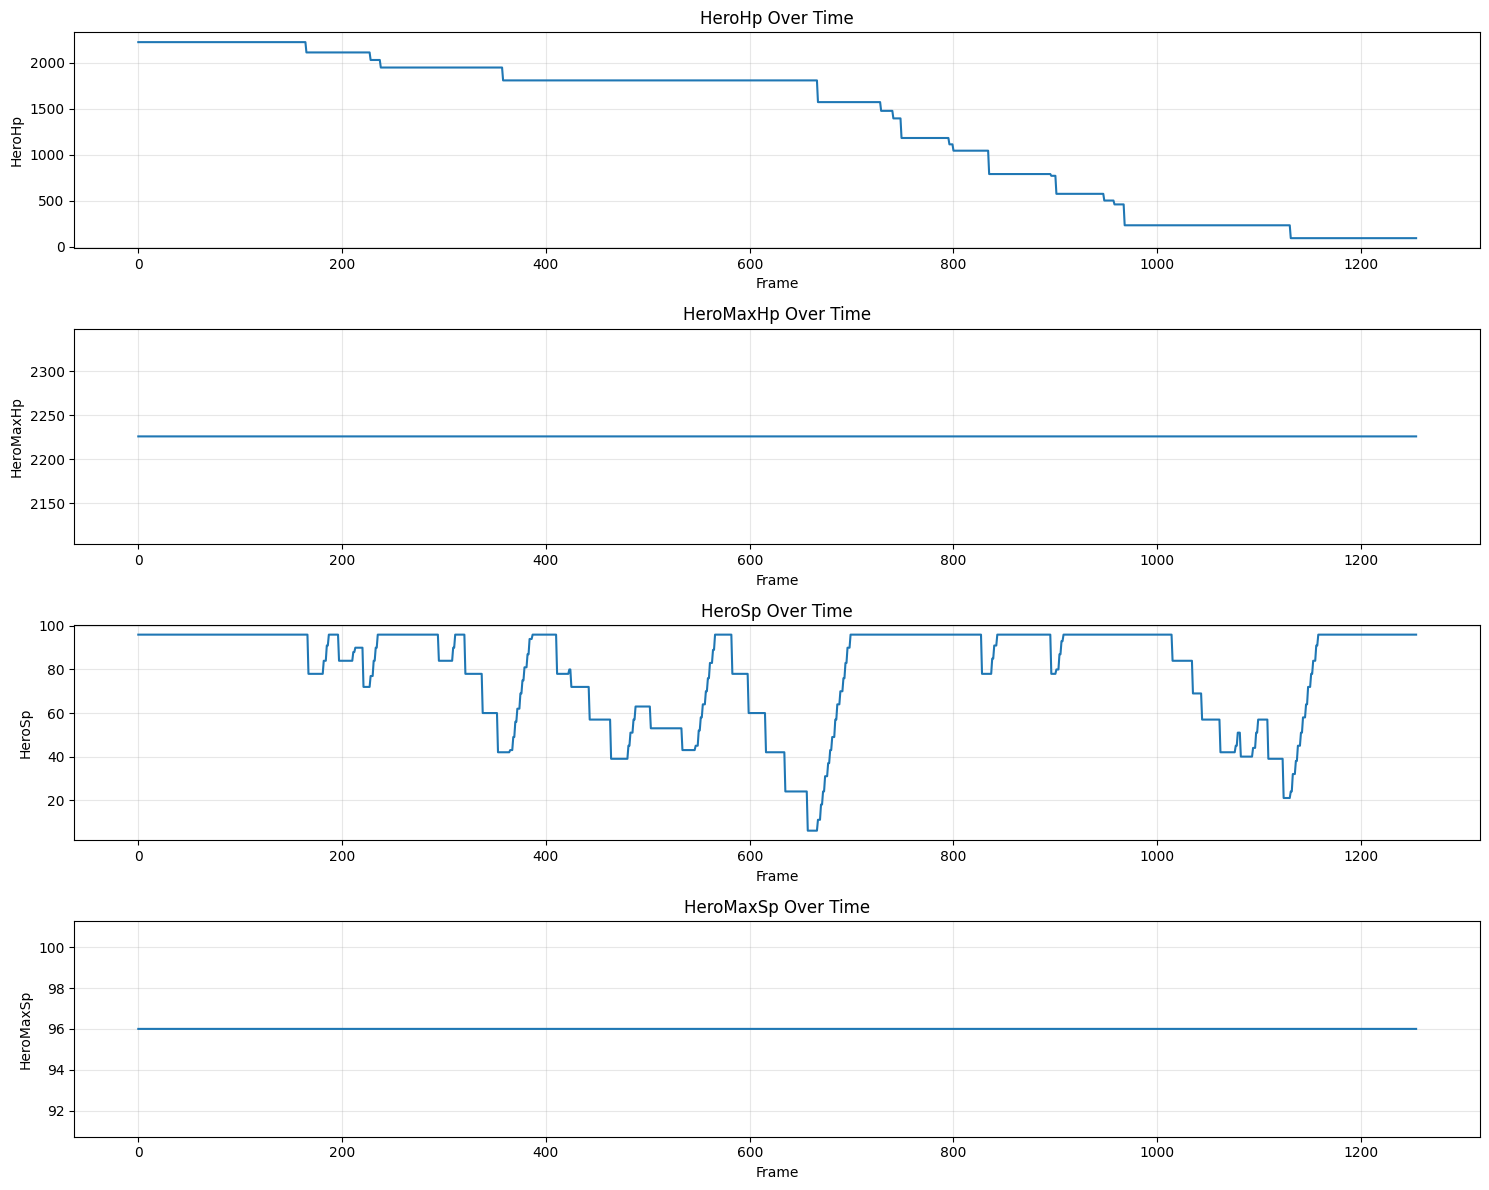

In [11]:
# Plot first few state attributes over time
num_attrs_to_plot = min(4, len(state_attrs))

fig, axes = plt.subplots(num_attrs_to_plot, 1, figsize=(15, 3 * num_attrs_to_plot))
if num_attrs_to_plot == 1:
    axes = [axes]

for i in range(num_attrs_to_plot):
    axes[i].plot(state[:, i])
    axes[i].set_ylabel(state_attrs[i])
    axes[i].set_xlabel('Frame')
    axes[i].grid(True, alpha=0.3)
    axes[i].set_title(f'{state_attrs[i]} Over Time')

plt.tight_layout()
plt.show()


## 7. Correlate Actions with State Changes


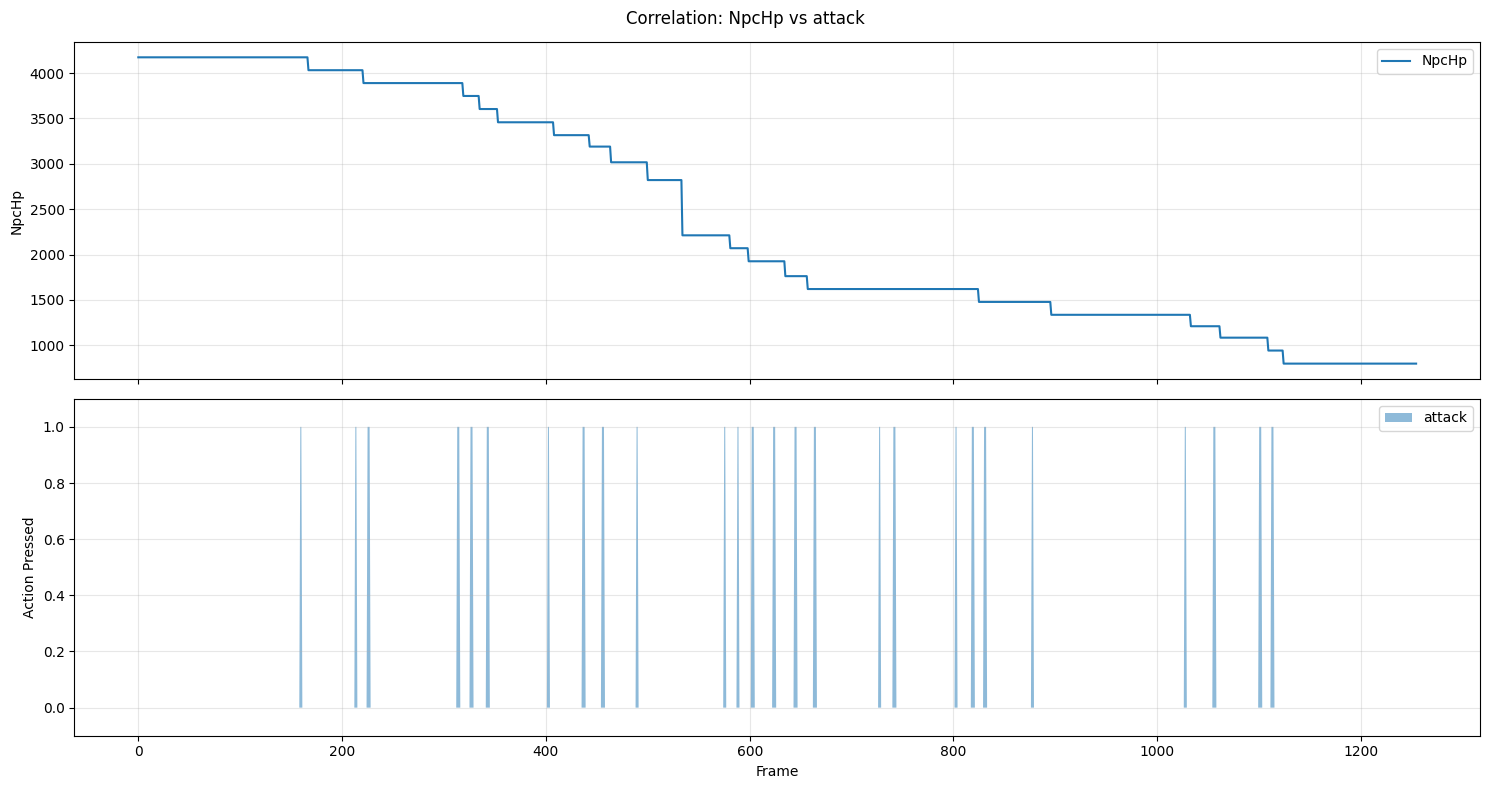

In [12]:
# Example: Look at a specific state attribute when certain actions are pressed
# Let's pick the first state attribute and first action as an example

if len(action_keys) > 0 and len(state_attrs) > 0:
    action_idx = 3
    state_idx = 11
    
    action_name = action_keys[action_idx]
    state_name = state_attrs[state_idx]
    
    # Get frames where action is pressed
    action_pressed = actions[:, action_idx]
    state_values = state[:, state_idx]
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
    
    # Plot state
    ax1.plot(state_values, label=state_name)
    ax1.set_ylabel(state_name)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot action
    ax2.fill_between(range(len(action_pressed)), 0, action_pressed, alpha=0.5, label=action_name)
    ax2.set_ylabel('Action Pressed')
    ax2.set_xlabel('Frame')
    ax2.set_ylim([-0.1, 1.1])
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.suptitle(f'Correlation: {state_name} vs {action_name}')
    plt.tight_layout()
    plt.show()
else:
    print("No actions or state attributes to compare")


## 8. Summary Statistics Across All Episodes


In [13]:
# Collect statistics from all episodes
import pandas as pd

episode_stats = []

for ep_name in sorted(episodes):
    ep = zarr_root[ep_name]
    stats = {
        'episode': ep_name,
        'frames': ep['frames'].shape[0],
        'fps': ep.attrs.get('fps', 'N/A'),
        'duration_sec': ep['frames'].shape[0] / ep.attrs.get('fps', 1) if ep.attrs.get('fps') else 'N/A',
        'total_actions': ep['actions'][:].sum(),
    }
    episode_stats.append(stats)

# Display as table
df_stats = pd.DataFrame(episode_stats)
print("Episode Statistics:")
print(df_stats.to_string(index=False))

# Summary
print("\nTotal Statistics:")
print(f"  Total frames: {df_stats['frames'].sum()}")
if df_stats['duration_sec'].dtype != 'object':
    print(f"  Total duration: {df_stats['duration_sec'].sum():.2f} seconds")
print(f"  Total actions: {df_stats['total_actions'].sum()}")


Episode Statistics:
  episode  frames       fps  duration_sec  total_actions
episode_0    1255 16.723634     75.043499           1179

Total Statistics:
  Total frames: 1255
  Total duration: 75.04 seconds
  Total actions: 1179


## 9. Export Sample Data

Export a small clip for inspection or visualization.


In [14]:
# Export first N frames as a video clip
import cv2

def export_clip(episode, start_frame, end_frame, output_path):
    """Export a clip from the episode as MP4."""
    frames = episode['frames'][start_frame:end_frame]
    fps = episode.attrs.get('fps', 30.0)
    height, width = frames.shape[2], frames.shape[3]
    
    # Create video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    for i in range(frames.shape[0]):
        # Convert from CHW to HWC
        frame = np.transpose(frames[i], (1, 2, 0))
        # frame is already in BGR format (from OpenCV)
        out.write(frame)
    
    out.release()
    print(f"Exported clip to: {output_path}")

# Example: export first 100 frames
# Uncomment to export:
# export_clip(episode, 0, 100, '../sample_clip.mp4')
